In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib notebook

In [3]:

# -------------------------------------------------------------------------
# Const
# -------------------------------------------------------------------------
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

In [4]:
def hvel(r,dph,bh,rmaxh,kh):
    x=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    return (bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**x

In [5]:
rh=np.linspace(0.01,maxR,100)

### read TC data

In [6]:
tc=pd.read_csv('tmp/inpData.txt',delimiter='\t')

In [7]:
tc

,time,lat,long,dp,vmax,64ne,64se,64sw,64nw,50ne,50se,50sw,50nw,34ne,34se,34sw,34nw
0,2015-03-08 12:00:00,-7.5,NaN,600.0,12.861111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-03-08 18:00:00,-7.8,NaN,1000.0,15.433333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-03-09 00:00:00,-8.1,NaN,1000.0,15.433333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-03-09 06:00:00,-8.5,NaN,1400.0,18.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-03-09 12:00:00,-9.0,NaN,2100.0,23.150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55560.0,55560.0,46300.0,55560.0
5,2015-03-09 18:00:00,-9.3,NaN,2800.0,28.294444,0.0,0.0,0.0,0.0,46300.0,37040.0,46300.0,37040.0,129640.0,120380.0,138900.0,111120.0
6,2015-03-10 00:00:00,-9.7,NaN,3200.0,30.866667,0.0,0.0,0.0,0.0,46300.0,37040.0,46300.0,37040.0,129640.0,120380.0,138900.0,111120.0
7,2015-03-10 06:00:00,-10.2,NaN,3600.0,33.438889,0.0,0.0,0.0,0.0,46300.0,37040.0,46300.0,37040.0,129640.0,120380.0,138900.0,120380.0


In [8]:
wind_radii=np.array([34.,50.,64.])*kt2ms

In [9]:
p64=tc.loc[7][['64ne','64se', '64sw', '64nw']].astype(float)

In [10]:
p50=tc.loc[7][['50ne','50se', '50sw', '50nw']].astype(float)

In [11]:
p34=tc.loc[7][['34ne','34se', '34sw', '34nw']].astype(float)

In [12]:
vmax=tc.loc[7].vmax

In [13]:
dp=tc.loc[7].dp

In [14]:
x_data=np.concatenate([p34.values,p50.values,p64.values])

In [15]:
x_data[x_data==0.]=np.nan

In [16]:
y_data=np.concatenate([np.ones(4)*wind_radii[0],np.ones(4)*wind_radii[1],np.ones(4)*wind_radii[2]])

In [17]:
y_data[np.isnan(x_data)]=np.nan

In [18]:
y_data=y_data[~np.isnan(y_data)]

In [19]:
x_data=x_data[~np.isnan(x_data)]

## Calculating using Scipy

In [20]:
# p[0] = B
# p[1] = Rmax
# p[2] = k
# p[3] = dp

from scipy.optimize import minimize, fmin_slsqp

def slsqp(R,V,maxR,rho,b,rmax,dp,k,vmax):
        dpmin=10.e2  # minimum value of  pressure drop P_central - P_env(=101kPa).
        dpmax=200.e2   # maximum value of  pressure drop P_central - P_env(=101kPa).
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?

        def func(p,x):
#                 return (p[0]/rho*(p[1]/x)**p[0]*p[3]*np.exp(-(p[1]/x)**p[0]))**(0.5+(x-p[1])/(maxR-p[1])*p[2]) # complete
                 return (p[0]/rho*(p[1]/x)**p[0]*dp*np.exp(-(p[1]/x)**p[0]))**(0.5+(x-p[1])/(maxR-p[1])*p[2]) # given dp
        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

#       def cf(p,x,y):
#           return vmax-func(p,p[1])
        def cf(p,x,y):
#                 return p[0]-vmax**2*rho*np.exp(1.)/p[3] # complete
                 return p[0]-vmax**2*rho*np.exp(1.)/dp # given dp



#        p0=[1.2,20000,.15,400.]
        p0=[1.2,20000,.5]


#        bp=[(.8,1.8),(5000,R.min()*.99),(0.,.15),(dpmin,dpmax)]
        bp=[(.8,2.5),(5000,R.min()*.99),(kmin,kmax)]

        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
        print ('L-BFGS-B', res1.x)
        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})
        print ('SLSQP', res2.x, res2.fun, res2.message)
        res = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        print (res)

        

        print ('Rmax= ', res1.x[1],res2.x[1])
        print ('F(Rmax)= ', cf(res1.x,0.,0.), cf(res2.x,0.,0.))
        return func,res1.x,res2.x, res




In [21]:
kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
kmax=0.25 # upper limit for k (->xn=.65)  WHY?

dpmin=10.e2  # minimum value of  pressure drop P_central - P_env(=101kPa).
dpmax=200.e2   # maximum value of  pressure drop P_central - P_env(=101kPa).
rvmaxmin=10.e3  # default minimum value of Rmax[m] 

bmin=0.8 # minimum value of holland parameter b
#bmax=2.5
bmax=1.8  # maximum value of holland parameter b
b0=1.2  # initial estimation of holland parameter b

rmax0=20.e3  # intial estimation for radius of maximum wind [m] (20km)
maxR=500.e3  # maximum radius of TC [m] (500Km)

In [22]:
fitf2,p2,p3,p4=slsqp(x_data,y_data,maxR,rhoa,b0,rvmaxmin,dp,kmin,vmax)

('L-BFGS-B', array([  8.58821211e-01,   1.19871936e+04,   0.00000000e+00]))
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.29404076033
            Iterations: 39
            Function evaluations: 198
            Gradient evaluations: 38
('SLSQP', array([  8.58820738e-01,   1.19872040e+04,   9.28361895e-18]), 3.29404076033188, 'Optimization terminated successfully.')
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.77358966084
            Iterations: 21
            Function evaluations: 110
            Gradient evaluations: 21
[  9.70942470e-01   1.04118769e+04   8.80077218e-02]
('Rmax= ', 11987.193587830327, 11987.204009221874)
('F(Rmax)= ', -0.1121212585934338, -0.1121217315982509)


In [23]:
idx = [3, 0, 1, 2] # change the order of the variables to match the arguments in hvel()

In [24]:
idx = [0, 1, 2] # change the order of the variables to match the arguments in hvel()

<IPython.core.display.Javascript object>


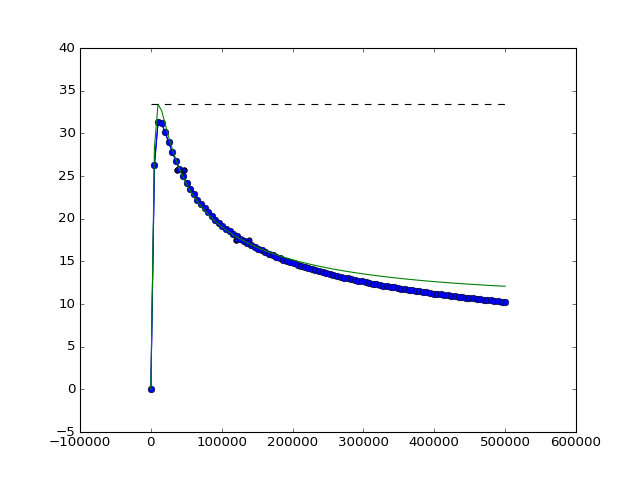

In [25]:
plt.figure()
try:
    plt.plot(rh, hvel(rh, dp, *p2[idx]), 'b-')
except:pass
try:
    plt.plot(rh, hvel(rh, dp,  *p3[idx]), 'o-')
except:pass
try:
    plt.plot(rh, hvel(rh, dp, *p4[idx]), 'g-')
except:pass

plt.scatter(x_data,y_data)
plt.plot(rh,np.ones(rh.size)*vmax,'k--')
plt.show()

In [26]:
bh, rmaxh, kh = p4

In [27]:
dph=dp

## Write outData file

In [ ]:
outdic={'time':  ,'xhc': ,'yhc': ,'b': ,'k': ,'rmax': ,'deltap': ,'vmax':  ,'vmax0':  ,'vtr':  ,'vtrx':  ,'vtry':  ,'bias':  ,'rmse':  }

In [ ]:
column_order=['time','lat','long','dp','vmax','64ne','64se','64sw','64nw','50ne','50se','50sw','50nw','34ne','34se','34sw','34nw']

In [ ]:
inpData.to_csv('tmp/outData.txt',index=False, columns=column_order, sep='\t')

## Plot profile

In [28]:
xl=np.linspace(-maxR, maxR,1000)
yl=np.linspace(-maxR, maxR,1000)
q1,q2=np.meshgrid(xl,yl)
vtx=-4.6
vty=3.35

In [29]:
def pres(r):
    return pn+dph*np.exp(-(rmaxh/r)**bh)

In [30]:
def hvel2d(l1,l2):
    r=np.sqrt(l1**2+l2**2)
    xh=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    ur=(bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**xh
    theta=np.arctan2(l2,l1)
    ux=-ur*np.sin(theta)
    uy=ur*np.cos(theta)
    return ux+vtx,uy+vty, pres(r)

In [31]:
zx,zy, pr=hvel2d(q1,q2)
vel=np.sqrt(zx**2+zy**2)

<IPython.core.display.Javascript object>


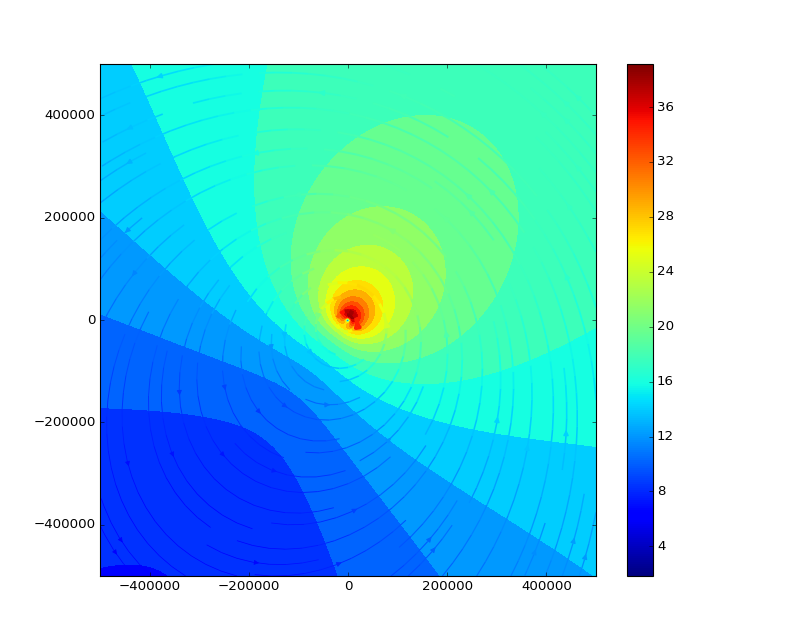

In [32]:
plt.figure(figsize=(10,8))
plt.contourf(q1,q2,vel,20)
plt.streamplot(q1,q2,zx,zy, color=vel, linewidth=0.1*vel)
plt.colorbar()
plt.show()